# Experiment 2: PCA on small dataset (Surface Elevation)

The small dataset contains 1 week of samples.

Takeaways:
* Few axes are needed to explain the variance of the data.


## Imports

In [1]:
%matplotlib notebook

In [2]:
# Import packages:
import mikeio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import sys

sys.path.append("../")
plt.style.use("seaborn-v0_8-whitegrid")

from Scripts import my_functions as mf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import HTML
from tqdm import tqdm

## Data Extraction

In [3]:
## Find the relative path to Data/DHI_wk_sim/Area.dfsu from current directory:

# Go up two levels from current directory:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

# Overwrite path:
path = os.path.join(path, "Data/DHI_wk_sim/Area.dfsu")

# Get first and last time step:
time = mikeio.open(path).time

# Load data:
data = mikeio.read(path,
                   time=slice(time[48], time[-1]))

In [4]:
data

<mikeio.Dataset>
dims: (time:353, element:17980)
time: 1996-12-19 00:00:00 - 1996-12-26 08:00:00 (353 records)
geometry: Dfsu2D (17980 elements, 10460 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Total water depth <Water Depth> (meter)
  2:  U velocity <u velocity component> (meter per sec)
  3:  V velocity <v velocity component> (meter per sec)

In [5]:
# Get surface elevation values:
data_vals = data.Surface_elevation.values

# Scale features:
scaler = StandardScaler().fit(data_vals)

# Transform features:
data_vals_scaled = scaler.transform(data_vals)


## PCA

In [6]:
# Create PCA object:
pca = PCA().fit(data_vals_scaled)

### Explained Variance
Since the data has been standardized, we will use the number of eigenvalues 
greater than 1 as the number of axes to keep in the PCA.

<IPython.core.display.Javascript object>


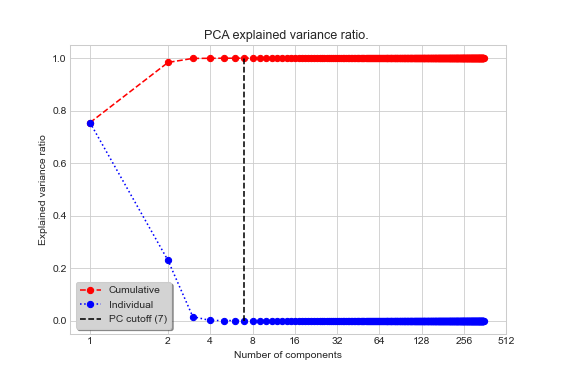

In [7]:
# Plot the PCA E.V.R:
fig1 = plt.figure(figsize=(7.5,5))
pca_x_ticks = np.arange(1, pca.n_components_+1, 1)
plt.plot(pca_x_ticks,
         np.cumsum(pca.explained_variance_ratio_),
         "o",
         linestyle="dashed",
         color="red")

plt.plot(pca_x_ticks,
         pca.explained_variance_ratio_,
         "o",
         linestyle="dotted",
         color="blue")

pc_keep = np.sum(pca.explained_variance_ > 1)

plt.vlines(pc_keep, 0, 1, colors="black", linestyles="dashed")

plt.xscale("symlog")
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")

pca_x_gridlines = np.array([2**i for i in range(10)])

plt.xticks(pca_x_gridlines,
           [str(pca_x_gridlines[i]) \
            for i in range(len(pca_x_gridlines))])


# Set legend:
plt.legend(["Cumulative", "Individual", f"PC cutoff ({pc_keep})"],
                 loc="best", frameon=True, fancybox=True,
                 shadow=True, framealpha=1, facecolor="lightgrey")

plt.title(f"PCA explained variance ratio. ")
plt.show()

In [8]:
# Save figure:
fig1.savefig("../Figures/Exp_2_small_PCA_EVR.png")

### Reconstruction vs Original

In [9]:
# Choose principal components:
princomps = pca.components_[:pc_keep]

# Transform features:
data_vals_scaled_pca = data_vals_scaled @ princomps.T

# Reconstruct features:
data_vals_scaled_recon = data_vals_scaled_pca @ princomps

# Rescale features:
data_vals_recon = scaler.inverse_transform(data_vals_scaled_recon)


<IPython.core.display.Javascript object>


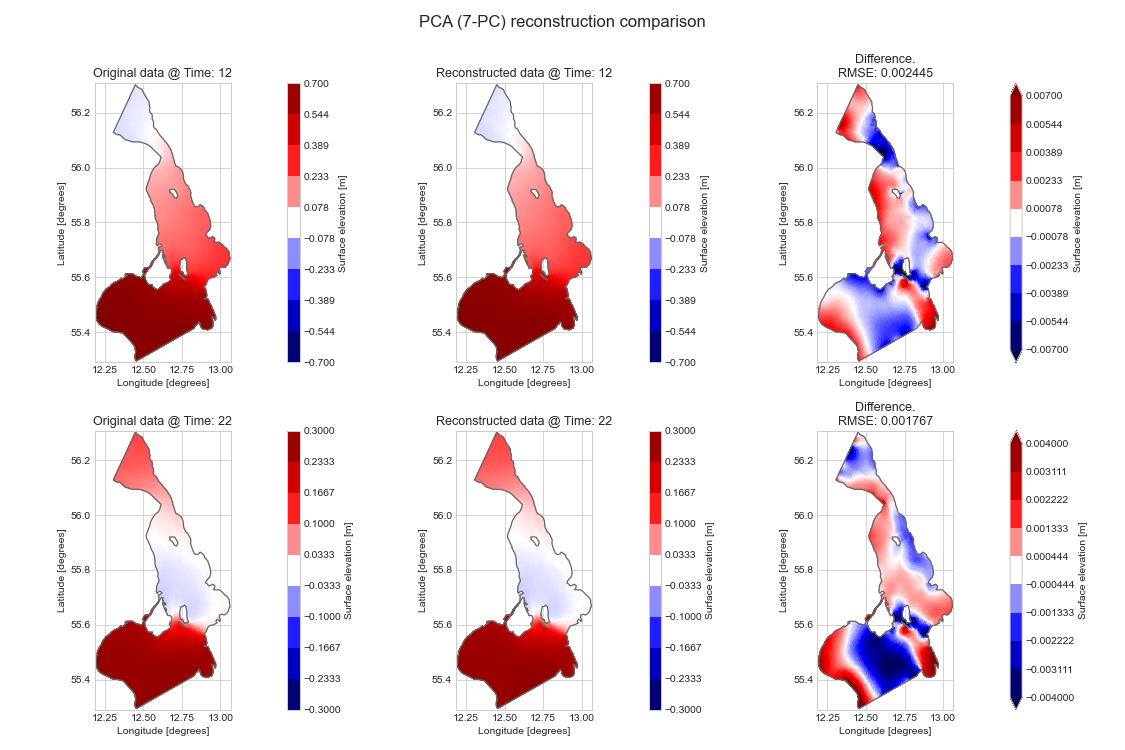

In [10]:
# Select plot times and plot data:
plot_times = [12, 22]
plot_data = data_vals[plot_times]
plot_data_recon = data_vals_recon[plot_times]

plot_obj = data.Surface_elevation[0].copy()
plot_rec_obj = data.Surface_elevation[0].copy()

# Create 2 by 3 subplot:
fig2, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loop over the two times:
for t in range(len(plot_times)):

    # Plot the original data:
    plot_obj.values = plot_data[t]
    
    cmap_max = np.quantile(np.abs(plot_obj.values), 0.99)
    digits = np.sum([cmap_max * (10**i) < 1 for i in range(5)])
    cmap_max = np.round(cmap_max, digits)
    
    plot_obj.plot(ax=axs[t,0], cmap="seismic",
                vmin = -cmap_max, vmax = cmap_max)
    axs[t,0].set_title(f"Original data @ Time: {plot_times[t]}")

    # Plot the reconstructed data:
    plot_rec_obj.values = plot_data_recon[t]
    
    cmap_max = np.quantile(np.abs(plot_rec_obj.values), 0.99)
    digits = np.sum([cmap_max * (10**i) < 1 for i in range(5)])
    cmap_max = np.round(cmap_max, digits)
    
    plot_rec_obj.plot(ax=axs[t,1], cmap="seismic",
                    vmin = -cmap_max, vmax = cmap_max)
    axs[t,1].set_title(
        f"Reconstructed data @ Time: {plot_times[t]}")

    # Compute the RMSE:
    rmse_diff = mf.rmse(plot_data[t], plot_data_recon[t])
    
    # Plot the difference:
    plot_obj.values = plot_data[t] - plot_data_recon[t]
    
    cmap_max = np.quantile(np.abs(plot_obj.values), 0.99)
    digits = np.sum([cmap_max * (10**i) < 1 for i in range(5)])
    cmap_max = np.round(cmap_max, digits)
    
    plot_obj.plot(ax=axs[t,2], cmap="seismic",
    vmin = -cmap_max, vmax = cmap_max)
    axs[t,2].set_title(f"Difference.\nRMSE: {rmse_diff:.6f}")

fig2.suptitle(f"PCA ({pc_keep}-PC) reconstruction comparison\n",
              fontsize=16)

fig2.tight_layout()

plt.show()


In [11]:
fig2.savefig(f"../Figures/Exp_2_small_PCA_{pc_keep}PC_comparison.png", dpi=100)